<a href="https://colab.research.google.com/github/OBulun/AN2DL_CH_2/blob/Francesco/v10_training_and_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [1]:
# from google.colab import drive
# drive.mount("/gdrive")
# Define current_dir correctly for Python (no backslashes for spaces)
# current_dir = "/gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2"
import os
current_dir = os.path.join(os.getcwd(), "an2dl2526c2")
# Use the correctly formatted path for the %cd magic command, quoting it for safety
# %cd "$current_dir"

## 1. Import Libraries

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
import gc
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
# !pip install torchview
# !pip install adabelief_pytorch
from torchview import draw_graph
from torch.utils.data import Dataset
from torchvision.transforms import RandAugment
from sklearn.preprocessing import LabelEncoder
from torchvision import models, transforms
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torchvision.models as models
from torch.optim import RAdam
from adabelief_pytorch import AdaBelief
import scipy.ndimage as ndimage # Import scipy.ndimage
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import sys
sys.path.append(os.getcwd()) # Added local path
# sys.path.append("/gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2")
import ResNet as ResCCLResNet


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


'pkill' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


PyTorch version: 2.5.1
Device: cuda


## **2. Data Loading**

In [3]:
# Assume datasets are in the current working directory, which is now correctly formatted
datasets_path = current_dir

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path             # Folder containing img_xxxx and mask_xxxx

# where the resized unmasked images will be saved
PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches")
PATCHES_OUT_MASKED = os.path.join(PATCHES_OUT, "masks")
# BLURRED_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches_blurred")

SUBMISSION_SOURCE_FOLDER = os.path.join(datasets_path, "test_data")
SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked", "submission_patches")
SUBMISSION_PATCHES_OUT_MASKS = os.path.join(SUBMISSION_PATCHES_OUT, "masks")

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks
Target_dimension = 224


Dataset path: e:\Challenge-2\AN2DL_CH_2\an2dl2526c2
Train data path: e:\Challenge-2\AN2DL_CH_2\an2dl2526c2\train_data
Train labels path: e:\Challenge-2\AN2DL_CH_2\an2dl2526c2\train_labels.csv
Test data path: e:\Challenge-2\AN2DL_CH_2\an2dl2526c2\test_data


<br> <br>

In [4]:
def load_images_from_folder(folder, mask_folder, target_size=TARGET_SIZE):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []

    # Get the list of files to iterate over
    file_list = sorted(os.listdir(folder))


    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        # load patches
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        # load masks
        mask_filename = filename.replace("img_", "mask_")
        mask_path = os.path.join(mask_folder, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        # Check if image was loaded successfully right away
        if img is None:
            print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        if mask is None:
            print(f"Warning: Failed to load mask at {mask_path}. Skipping.")
            continue

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]    # (H, W, 3)

        # Resize image and mask to the target size to ensure consistency, before concatenation
        #img = cv2.resize(img, target_size)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Normalize mask
        mask = (mask > 128).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)  # (H, W, 1)

        # Concatenate image and mask
        img = np.concatenate([img, mask], axis=-1)  # (H, W, 4)

        images.append(img)

    return np.array(images)

In [5]:
# Load the patches' images, both colored and the relative masks
train_images = load_images_from_folder(
    PATCHES_OUT,
    PATCHES_OUT_MASKED
)

print(f"Loaded {len(train_images)} images")
print("Loaded images:", train_images.shape)
print("Mask unique values:", np.unique(train_images[..., -1]))



Loading images from train_patches: 100%|██████████| 3259/3259 [00:10<00:00, 320.19it/s]


Loaded 3258 images
Loaded images: (3258, 224, 224, 4)
Mask unique values: [0. 1.]


## EXPLORATION AND DATA ANALYSIS

In [6]:
# Add this cell before your visualization
print(f"train_images shape: {train_images.shape}")

train_images shape: (3258, 224, 224, 4)


In [7]:
# 1. Read the original CSV with labels
df_labels = pd.read_csv(train_labels_path)

# 2. Create a dictionary to map images in labels
# The original CSV uses 'sample_index' for filenames like 'img_0001.png'
image_to_label = dict(zip(df_labels['sample_index'], df_labels['label']))

# 3. Obtain labels and names of the patches
patch_labels = []
filtered_patch_filenames = [] # This will store the filenames that are actually processed

for patch_file_name in sorted(os.listdir(PATCHES_OUT)):
    if patch_file_name == "masks":
        continue

    # Check if the file is an image
    if not patch_file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue # Skip non-image files

    # Extract original image number from patch filename
    # Assuming patch filenames are like 'img_XXXX_patchYYY.png' or 'img_XXXX_pY.png'
    # And original image names in CSV are like 'img_XXXX.png'
    try:
        # Extract 'XXXX' part from 'img_XXXX_...' using parts[1]
        img_number_str = patch_file_name.split('_')[1]
        original_image_name_full = f"img_{img_number_str}.png"
    except (IndexError, ValueError):
        # If parsing fails, this patch filename is not in the expected format, skip it
        continue

    if original_image_name_full in image_to_label:
        patch_labels.append(image_to_label[original_image_name_full])
        filtered_patch_filenames.append(patch_file_name)
    else:
        # If the original image for this patch is not in the original labels,
        # append "UNKNOWN" and also include the filename to maintain length consistency
        patch_labels.append("UNKNOWN")
        filtered_patch_filenames.append(patch_file_name)

# 4. Create a temporary DataFrame to visualize metrics
# Use the filtered_patch_filenames list, which is guaranteed to match the length of patch_labels
df_patches = pd.DataFrame({'patch': filtered_patch_filenames, 'label': patch_labels})

# 5. Compute the distributions
label_counts = df_patches['label'].value_counts()
label_percentages = df_patches['label'].value_counts(normalize=True) * 100

print("Number of patches per class:")
print(label_counts)

print("\nClass distribution in percentage:")
print(label_percentages.round(2))

Number of patches per class:
label
Luminal B          1143
Luminal A           889
HER2(+)             876
Triple negative     350
Name: count, dtype: int64

Class distribution in percentage:
label
Luminal B          35.08
Luminal A          27.29
HER2(+)            26.89
Triple negative    10.74
Name: proportion, dtype: float64


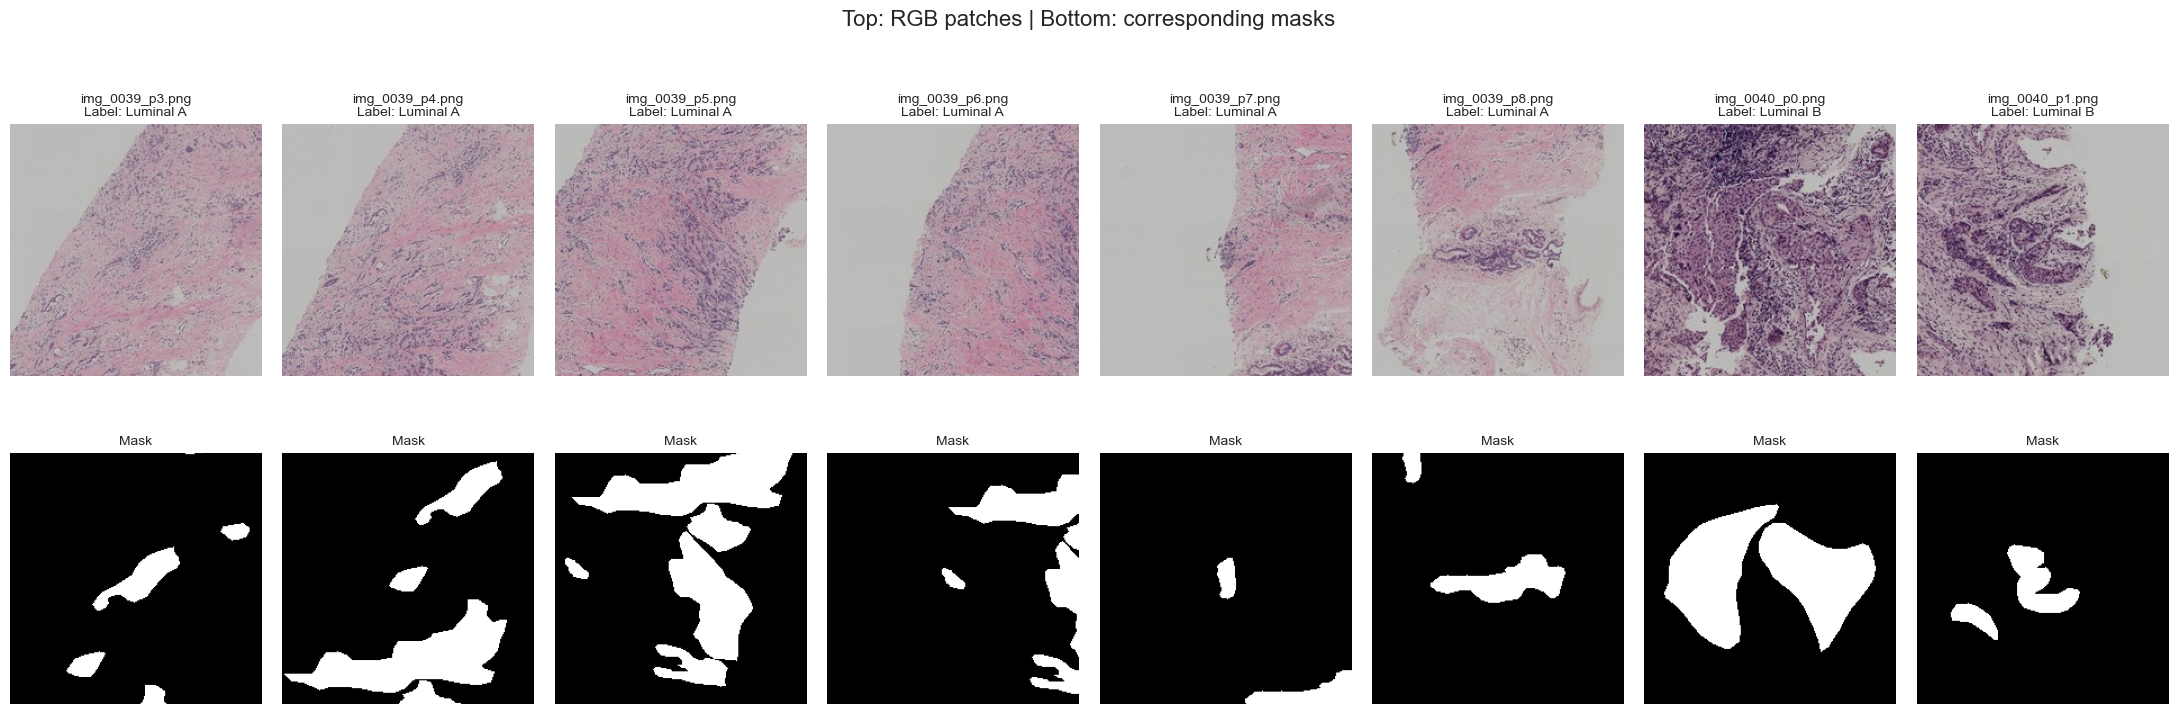

In [8]:
# Number of images to display
num_img = 8
start_img = 194

# Create subplots
fig, axes = plt.subplots(2, num_img, figsize=(22, 8))

for i in range(num_img):
    idx = start_img + i

    # --- RGB PATCH (first row)
    ax_rgb = axes[0, i]
    ax_rgb.imshow(np.clip(train_images[idx][..., :3], 0, 1))
    label = df_patches['label'].iloc[idx]
    ax_rgb.set_title(f"{df_patches['patch'].iloc[idx]}\nLabel: {label}", fontsize=10)
    ax_rgb.axis('off')

    # --- MASK PATCH (second row)
    ax_mask = axes[1, i]
    ax_mask.imshow(train_images[idx][..., 3], cmap='gray')
    ax_mask.set_title("Mask", fontsize=10)
    ax_mask.axis('off')

    fig.suptitle("Top: RGB patches | Bottom: corresponding masks", fontsize=16)

plt.tight_layout()
plt.show()


## SPLIT THE DATASET

In [9]:
# Directory contenente le patch
patched_output_dir = Path(PATCHES_OUT)

# Carica le labels originali
original_labels_df = pd.read_csv(train_labels_path)
print(f"Loaded {len(original_labels_df)} original labels")

# Crea mapping: numero immagine originale -> label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row['sample_index'] if 'sample_index' in row else row.iloc[0]
    label = row['label'] if 'label' in row else row.iloc[1]
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label
print(f"Mapping created for {len(image_to_label)} original images")

# Trova tutte le patch
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} patch files")

# Associa le patch alle labels
patch_data = []
for patch_file in tqdm(patch_files, desc="Mapping patches to labels"):
    fname = patch_file.stem  # e.g., img_0042_patch03
    parts = fname.split('_')
    if len(parts) < 3:
        continue
    try:
        original_img_number = int(parts[1])
        label = image_to_label.get(original_img_number, None)
        if label is None:
            continue
        patch_data.append({
            'filename': patch_file.name,
            'original_img_number': original_img_number,
            'label': label
        })
    except ValueError:
        continue

patches_df = pd.DataFrame(patch_data)
print(f"Successfully mapped {len(patches_df)} patches")

assert not np.any(pd.isna(patches_df["label"]))

# Salva CSV per riferimento futuro
patched_csv_path = Path(datasets_path) / "train_labels_patched.csv"
patches_df.to_csv(patched_csv_path, index=False)
print(f"Patch labels CSV saved at {patched_csv_path}")

# --- Split del dataset basato sull'immagine originale ---
original_img_numbers = patches_df['original_img_number'].unique()
original_labels = [image_to_label[num] for num in original_img_numbers]

# Codifica le labels
label_encoder = LabelEncoder()
original_labels_encoded = label_encoder.fit_transform(original_labels)

# SAVE LABEL ENCODER
label_encoder_path = Path(datasets_path) / "label_encoder.npy"
np.save(label_encoder_path, label_encoder)
print("Saved label encoder to:", label_encoder_path)


# Split originale in train/temp
train_img_nums, temp_img_nums, train_img_labels, temp_img_labels = train_test_split(
    original_img_numbers,
    original_labels_encoded,
    test_size=0.3,
    random_state=SEED,
    stratify=original_labels_encoded
)

# Split temp in validation/test
val_img_nums, test_img_nums, val_img_labels, test_img_labels = train_test_split(
    temp_img_nums,
    temp_img_labels,
    test_size=0.1,
    random_state=SEED,
    stratify=temp_img_labels
)

train_img_set, val_img_set, test_img_set = set(train_img_nums), set(val_img_nums), set(test_img_nums)



# ===================================================
#  SPLIT USANDO GLI INDICI (NO RELOAD, NO RAM SPIKE)
# ===================================================

assert len(train_images) == len(patches_df)   # Uncomment just for a check

train_indices = []
val_indices = []
test_indices = []

for i, row in patches_df.iterrows():
    orig = row["original_img_number"]
    if orig in train_img_set:
        train_indices.append(i)
    elif orig in val_img_set:
        val_indices.append(i)
    elif orig in test_img_set:
        test_indices.append(i)

train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

# Slice diretto dagli array già caricati
X_train = train_images[train_indices]
X_val = train_images[val_indices]
X_test = train_images[test_indices]

y_train = patches_df.iloc[train_indices]["label"].values
y_val = patches_df.iloc[val_indices]["label"].values
y_test = patches_df.iloc[test_indices]["label"].values

# Use label encoder
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)


print(f"Training patches: {X_train.shape}")
print(f"Validation patches: {X_val.shape}")
print(f"Test patches: {X_test.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

del train_images
gc.collect()
None


Loaded 691 original labels
Mapping created for 691 original images
Found 3258 patch files


Mapping patches to labels: 100%|██████████| 3258/3258 [00:00<00:00, 281637.31it/s]

Successfully mapped 3258 patches
Patch labels CSV saved at e:\Challenge-2\AN2DL_CH_2\an2dl2526c2\train_labels_patched.csv
Saved label encoder to: e:\Challenge-2\AN2DL_CH_2\an2dl2526c2\label_encoder.npy


Training patches: (2259, 224, 224, 4)
Validation patches: (874, 224, 224, 4)
Test patches: (125, 224, 224, 4)
Number of classes: 4


<br> <br>

## Image Augmentation

In [10]:
# ImageNet normalization values
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


def apply_geometric(rgb, mask, size, train):
    if not train:
        rgb = TF.resize(rgb, size)
        mask = TF.resize(mask, size, interpolation=TF.InterpolationMode.NEAREST)
        return rgb, mask

    if random.random() > 0.5:
        rgb = TF.hflip(rgb)
        mask = TF.hflip(mask)

    if random.random() > 0.5:
        rgb = TF.vflip(rgb)
        mask = TF.vflip(mask)

    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
        rgb = TF.rotate(rgb, angle)
        mask = TF.rotate(mask, angle)

    resize_size = int(size * 1.1)
    rgb = TF.resize(rgb, resize_size)
    mask = TF.resize(mask, resize_size, interpolation=TF.InterpolationMode.NEAREST)

    i, j, h, w = transforms.RandomCrop.get_params(
        rgb, output_size=(size, size)
    )
    rgb = TF.crop(rgb, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    return rgb, mask


class RGBMaskAugmentationAdaptive:
    def __init__(self, size, train=True):
        self.size = size
        self.train = train
        self.randaug = RandAugment(num_ops=2, magnitude=9)

    def __call__(self, img):
        rgb = img[..., :3]
        mask = img[..., 3:]

        rgb = torch.from_numpy(rgb).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).permute(2, 0, 1).float()

        # --- geometric (sync RGB + mask)
        rgb, mask = apply_geometric(rgb, mask, self.size, self.train)

        # --- adaptive color augmentation (RGB only)
        if self.train:
            rgb_uint8 = (rgb.clamp(0, 1) * 255).to(torch.uint8)
            rgb_uint8 = self.randaug(rgb_uint8)
            rgb = rgb_uint8.float() / 255.0

        rgb = TF.normalize(rgb, IMAGENET_MEAN, IMAGENET_STD)
        return torch.cat([rgb, mask], dim=0)


class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

train_transform = RGBMaskAugmentationAdaptive(
    Target_dimension,
    train=True
)

val_test_transform = RGBMaskAugmentationAdaptive(
    Target_dimension,
    train=False
)


In [11]:
# Define a set of transformations for data augmentation and scale the images

# ImageNet normalization values
# IMAGENET_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_STD = [0.229, 0.224, 0.225]


# class RGBMaskAugmentation:
#     def __init__(self, size, train=True):
#         self.size = size
#         self.train = train

#     def __call__(self, img):
#         """
#         img: numpy array (H, W, 4) -> RGB + mask
#         """
#         Split RGB and mask
#         rgb = img[..., :3]
#         mask = img[..., 3:]

#         Convert to torch tensor (C, H, W)
#         rgb = torch.from_numpy(rgb).permute(2, 0, 1).float()
#         mask = torch.from_numpy(mask).permute(2, 0, 1).float()

#         ---------------------------
#         GEOMETRIC TRANSFORMS
#         ---------------------------
#         if self.train:
#             Random horizontal flip
#             if random.random() > 0.5:
#                 rgb = TF.hflip(rgb)
#                 mask = TF.hflip(mask)

#             Random vertical flip
#             if random.random() > 0.5:
#                 rgb = TF.vflip(rgb)
#                 mask = TF.vflip(mask)

#             Random rotation (multiples of 90°)
#             angle = random.choice([0, 90, 180, 270])
#             if angle != 0:
#                 rgb = TF.rotate(rgb, angle)
#                 mask = TF.rotate(mask, angle)

#             Random crop after resize
#             resize_size = int(self.size * 1.1)
#             rgb = TF.resize(rgb, resize_size)
#             mask = TF.resize(mask, resize_size, interpolation=TF.InterpolationMode.NEAREST)

#             i, j, h, w = transforms.RandomCrop.get_params(
#                 rgb, output_size=(self.size, self.size)
#             )
#             rgb = TF.crop(rgb, i, j, h, w)
#             mask = TF.crop(mask, i, j, h, w)

#         else:
#             rgb = TF.resize(rgb, self.size)
#             mask = TF.resize(mask, self.size, interpolation=TF.InterpolationMode.NEAREST)

#         ---------------------------
#         COLOR TRANSFORMS (RGB ONLY)
#         ---------------------------
#         if self.train:
#             rgb = TF.adjust_brightness(rgb, random.uniform(0.7, 1.3))
#             rgb = TF.adjust_contrast(rgb, random.uniform(0.7, 1.3))
#             rgb = TF.adjust_saturation(rgb, random.uniform(0.7, 1.3))
#             rgb = TF.adjust_hue(rgb, random.uniform(-0.05, 0.05))

#             if random.random() < 0.2:
#                 rgb = TF.gaussian_blur(rgb, kernel_size=3)

#         ---------------------------
#         CONCAT RGB + MASK
#         ---------------------------
#         rgb = TF.normalize(rgb, mean=IMAGENET_MEAN, std=IMAGENET_STD)
#         img_out = torch.cat([rgb, mask], dim=0)


#         return img_out


# train_transform = RGBMaskAugmentation(Target_dimension, train=True)
# val_test_transform = RGBMaskAugmentation(Target_dimension, train=False)


# class AugmentedDataset(Dataset):
#     def __init__(self, images, labels, transform=None):
#         self.images = images
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img = self.images[idx]
#         label = self.labels[idx]

#         if self.transform:
#             img = self.transform(img)

#         return img, label


In [12]:
# FOR NOW DON'T USE MIXUP + CUTMIX, SINCE INTRODUCING THE MASK AS 4TH CHANNEL
# WE WOULD DO A MIX BETWEEN DIFFERENT MASKS IF WE DON'T COMMENT THEM OUT

# # Mixup ("superimpose" two images like 60% Luminal A and 40% HER2(+))
# def mixup_data(x, y, alpha=0.4):
#     lam = np.random.beta(alpha, alpha)
#     batch_size = x.size()[0]
#     index = torch.randperm(batch_size)

#     mixed_x = lam * x + (1 - lam) * x[index]
#     y_a, y_b = y, y[index]

#     return mixed_x, y_a, y_b, lam

# # Cutmix (cut a portion of an image and insert it in another image with a different label)
# def cutmix_data(x, y, alpha=1.0):
#     lam = np.random.beta(alpha, alpha)
#     batch_size, _, h, w = x.size()
#     index = torch.randperm(batch_size)

#     cx = np.random.randint(w)
#     cy = np.random.randint(h)
#     cut_w = int(w * np.sqrt(1 - lam))
#     cut_h = int(h * np.sqrt(1 - lam))

#     x1 = np.clip(cx - cut_w // 2, 0, w)
#     x2 = np.clip(cx + cut_w // 2, 0, w)
#     y1 = np.clip(cy - cut_h // 2, 0, h)
#     y2 = np.clip(cy + cut_h // 2, 0, h)

#     x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

#     y_a, y_b = y, y[index]
#     lam = 1 - ((x2 - x1) * (y2 - y1) / (h * w))

#     return x, y_a, y_b, lam


In [13]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (4, 224, 224)
Number of Classes: 4


In [14]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)

train_ds = AugmentedDataset(X_train, y_train, transform=train_transform)
val_ds   = AugmentedDataset(X_val,   y_val,   transform=val_test_transform)
test_ds  = AugmentedDataset(X_test,  y_test,  transform=val_test_transform)


In [15]:
# Define the batch size
BATCH_SIZE = 32

In [16]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [17]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [18]:
# Get one batch from the training data loader
# for xb, yb in train_loader:
#     print("Features batch shape:", xb.shape)
#     print("Labels batch shape:", yb.shape)
#     break  # Stop after getting one batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6813945].


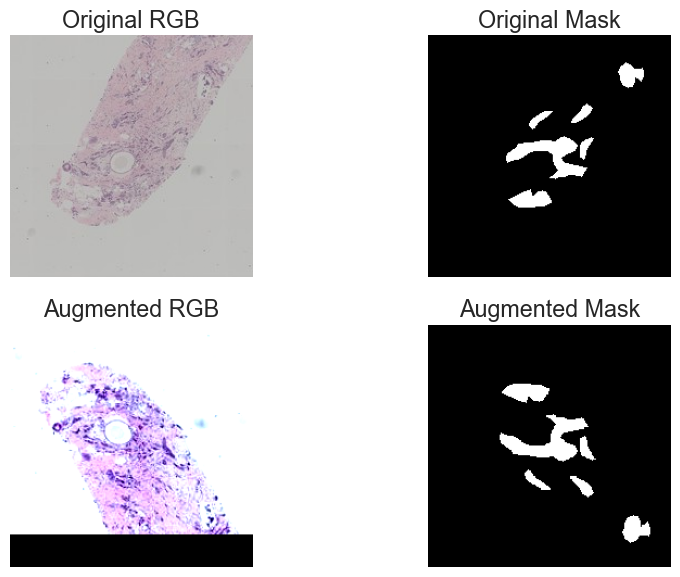

In [19]:
# Plot an original image and its augmented copy
idx = 10  # choose the image to be compared

# Original
original_np = X_train[idx]
orig_rgb = original_np[..., :3]
orig_mask = original_np[..., 3]

# Augmented
augmented_tensor, _ = train_ds[idx]
augmented_np = augmented_tensor.permute(1, 2, 0).numpy()
aug_rgb = augmented_np[..., :3]
aug_mask = augmented_np[..., 3]

# Plot
plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
plt.title("Original RGB")
plt.imshow(orig_rgb)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Original Mask")
plt.imshow(orig_mask, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Augmented RGB")
plt.imshow(aug_rgb)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Augmented Mask")
plt.imshow(aug_mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


## **4. Network Parameters**

In [20]:
# Number of training epochs
LEARNING_RATE = 5e-4
EPOCHS = 1000
PATIENCE = 25

# Regularisation
DROPOUT_RATE = 0.2          # Dropout probability
L1_LAMBDA = 0               # L1 penalty
L2_LAMBDA = 1e-3            # L2 penalty

# Set up loss function and optimizer
# criterion = nn.CrossEntropyLoss()

# # Compute class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# criterion = nn.CrossEntropyLoss(weight=class_weights)  # Set up cost function with weighted losses


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha  # class weights tensor or None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):

        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(logits, targets)
        pt = torch.exp(-ce_loss)  # probability of the correct class

        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# compute class weights (balanced)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = FocalLoss(alpha=class_weights, gamma=2)


# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)


Epochs: 1000
Batch Size: 32
Learning Rare: 0.0005
Dropout Rate: 0.2
L1 Penalty: 0
L2 Penalty: 0.001


## **Model Training**

In [21]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [22]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)


        # To use MixUp / CutMix
        # r = np.random.rand()
        # if r < 0.33:
        #     inputs_mix, targets_a, targets_b, lam = mixup_data(inputs, targets)
        # elif r < 0.66:
        #     inputs_mix, targets_a, targets_b, lam = cutmix_data(inputs, targets)
        # else:
        #     inputs_mix, targets_a, targets_b, lam = inputs, targets, targets, 1.0

        # No MixUp / CutMix (disabled for RGB + mask)
        inputs_mix = inputs
        targets_a = targets
        targets_b = targets
        lam = 1.0

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs_mix)

            # Mixup / Cutmix loss
            loss = lam * criterion(logits, targets_a) + (1 - lam) * criterion(logits, targets_b)

            # Regularization terms
            # l1_norm = sum(p.abs().sum() for p in model.parameters())
            # l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            # loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm



        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [23]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [24]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        if epoch % 5 == 0:
                            writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [25]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## ***ResCCL / ResNet50 model***

In [26]:
# import sys
sys.path.append(os.getcwd()) # Added local path
# # sys.path.append("/gdrive/My Drive/AN2DL Challenge 2")
# import ResNet as ResCCLResNet


In [27]:
def clean_state_dict(sd):
    out = {}
    for k, v in sd.items():
        for p in ("module.", "model.", "encoder.", "backbone."):
            if k.startswith(p):
                k = k[len(p):]
        out[k] = v
    return out

In [32]:
class ResCCL_ResNet50_4ch(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True,
                 resccl_ckpt_path="models/retccl.pth"):
        super().__init__()

        # ---------------------------
        # BACKBONE ResCCL (NON torchvision)
        # ---------------------------
        self.backbone = ResCCLResNet.resnet50(
            num_classes=128,    # testa SSL (verrà rimossa)
            mlp=False,
            two_branch=False,
            normlinear=True
        )


        # ---------------------------
        # LOAD ResCCL PRETRAINED WEIGHTS
        # ---------------------------
        sd = torch.load(resccl_ckpt_path, map_location="cpu")
        if isinstance(sd, dict) and "state_dict" in sd:
            sd = sd["state_dict"]

        sd = clean_state_dict(sd)

        # rimuove la testa SSL
        sd = {k: v for k, v in sd.items() if not k.startswith("fc.")}

        msg = self.backbone.load_state_dict(sd, strict=False)
        print("Missing keys:", msg.missing_keys)
        print("Unexpected keys:", msg.unexpected_keys)


        # ---------------------------
        # ADATTA PRIMO CONV A 4 CANALI
        # ---------------------------
        old_conv = self.backbone.conv1

        new_conv = nn.Conv2d(
            in_channels=4,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )

        with torch.no_grad():
            new_conv.weight[:, :3] = old_conv.weight
            new_conv.weight[:, 3] = old_conv.weight.mean(dim=1)

        self.backbone.conv1 = new_conv


        # ---------------------------
        # CLASSIFIER (UGUALE A PRIMA)
        # ---------------------------
        if hasattr(self.backbone.fc, "in_features"):
            in_features = self.backbone.fc.in_features
        else:
            in_features = self.backbone.fc.weight.shape[1]

        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

        # ---------------------------
        # FREEZE BACKBONE
        # ---------------------------
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        for param in self.backbone.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


## TRANSFER LEARNING

In [33]:
# Transfer learning model
tl_model = ResCCL_ResNet50_4ch(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=True
).to(device)

w = tl_model.backbone.conv1.weight
print(w.shape)     # (64, 4, 7, 7)

# check che solo fc sia trainabile nel TL
trainable = [n for n, p in tl_model.named_parameters() if p.requires_grad]
print(trainable[:5], "...", len(trainable))


Missing keys: ['fc.weight', 'fc.bias']
Unexpected keys: []
torch.Size([64, 4, 7, 7])
['backbone.fc.1.weight', 'backbone.fc.1.bias'] ... 2


In [34]:
# Create datasets with augmentation
train_ds = AugmentedDataset(X_train, y_train, transform=train_transform)
val_ds   = AugmentedDataset(X_val,   y_val,   transform=val_test_transform)

In [35]:
# Loader
train_loader = make_loader(train_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds,   BATCH_SIZE, shuffle=False, drop_last=False)

In [36]:
# Define the optimizer
optimizer = torch.optim.AdamW(
    tl_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=L2_LAMBDA
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [37]:
# Experiment name
experiment_name = "ResCCL_transfer"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

In [40]:
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name="ResCCL_transfer",
    patience=PATIENCE
)

final_val_acc = round(max(tl_history['val_f1']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')

Training 1000 epochs...


OSError: [Errno 22] Invalid argument

NameError: name 'tl_history' is not defined

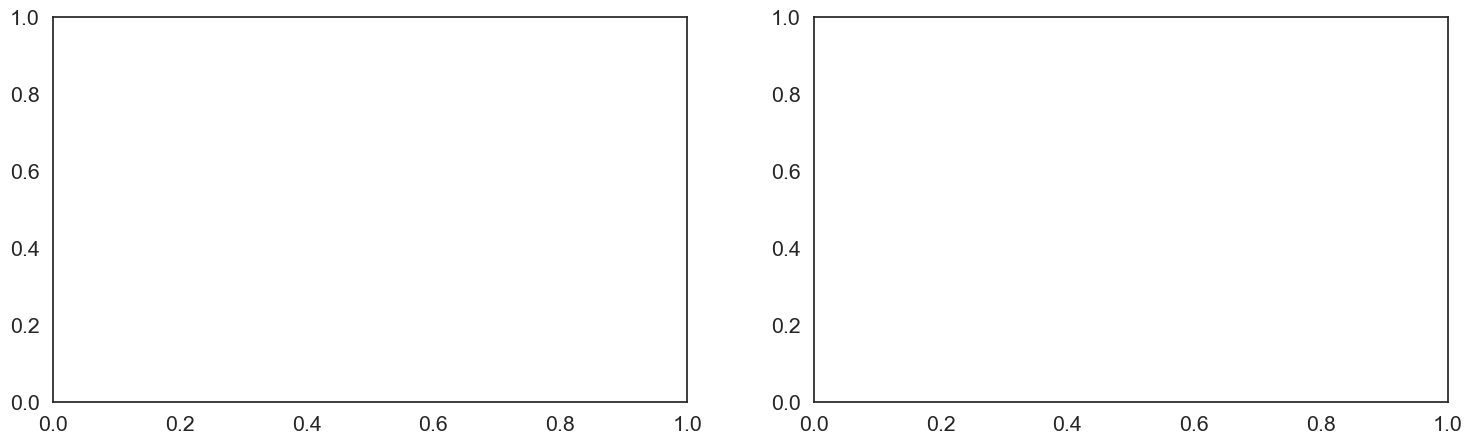

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(tl_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(tl_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = tl_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## FINE-TUNING

In [ ]:
# Fine-tuning model
ft_model = ResCCL_ResNet50_4ch(
    num_classes=num_classes,
    dropout_rate=0.3,
    freeze_backbone=False
).to(device)

ft_model.load_state_dict(
    torch.load("models/ResCCL_transfer_model.pt", map_location=device)
)


for param in ft_model.backbone.parameters():
    param.requires_grad = False

for param in ft_model.backbone.fc.parameters():
    param.requires_grad = True


In [ ]:
# Fine-tuning datasets (same augmentation of TL)
train_transform_ft = RGBMaskAugmentationAdaptive(
    Target_dimension,
    train=True
)
train_ft_ds = AugmentedDataset(X_train, y_train, transform=train_transform_ft)
val_ft_ds   = AugmentedDataset(X_val,   y_val,   transform=val_test_transform)

In [ ]:
# Fine-tuning loaders
train_ft_loader = make_loader(train_ft_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_ft_loader = make_loader(val_ft_ds, BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Define the optimizer
optimizer = torch.optim.AdamW(
    ft_model.backbone.fc.parameters(),
    lr=1e-4,
    weight_decay=L2_LAMBDA
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
# Experiment name
experiment_name = "ResCCL_finetuning_first_15_epochs"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

In [ ]:
%%time
# Fine-tune the model
ft_model_first_15_epochs, ft_history_first_15_epochs = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=15,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name="ResCCL_finetuning_first_15_epochs",
    patience=5
)

final_val_acc_first_15_epochs = round(max(ft_history_first_15_epochs['val_f1']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc_first_15_epochs}%')

In [ ]:
writer.close()

for param in ft_model.backbone.layer4.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(
    [
        {"params": ft_model.backbone.layer4.parameters(), "lr": 2e-5},
        {"params": ft_model.backbone.fc.parameters(),     "lr": 5e-5},
    ],
    weight_decay=L2_LAMBDA
)


In [ ]:
# Experiment name
experiment_name = "ResCCL_finetuning"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

In [ ]:
%%time
# Fine-tune the model
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS - 15,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name="ResCCL_finetuning",
    patience=20
)

final_val_acc = round(max(ft_history['val_f1']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(ft_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(ft_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(ft_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = ft_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

<br> <br>

## CLASS ACTIVATION MAPS (CAM)

In [ ]:
def visualize_cam(
    model,
    images_tensor,     # (B,4,H,W)
    original_images,   # list of RGB images from X_val
    masks,             # list of 2D masks (from 4th channel)
    num_to_labels,
    target_class=None,
    patch_names=None
):
    model.eval()

    # ---------------------------------
    # 1. Hook sull’ultimo blocco conv (ResNet50)
    # ---------------------------------
    target_layer = model.backbone.layer4[-1]
    activations = []

    def hook_fn(m, i, o):
        activations.append(o)

    handle = target_layer.register_forward_hook(hook_fn)

    # ---------------------------------
    # 2. Pesi del classifier
    # backbone.fc = [Dropout, Linear]
    # ---------------------------------
    fc_weights = model.backbone.fc[1].weight.data.cpu().numpy()

    # ---------------------------------
    # 3. Forward
    # ---------------------------------
    with torch.no_grad():
        outputs = model(images_tensor)
        preds = outputs.argmax(dim=1).cpu().numpy()

    handle.remove()

    acts = activations[0].cpu().numpy()  # (B,C,H,W)
    num_images = len(images_tensor)

    # ---------- PLOT ----------
    plt.figure(figsize=(3 * num_images, 6))

    for i in range(num_images):
        class_idx = target_class if target_class is not None else preds[i]

        # ---- CAM ----
        cam = np.zeros(acts.shape[2:], dtype=np.float32)
        for w, feat in zip(fc_weights[class_idx], acts[i]):
            cam += w * feat

        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)

        # resize CAM to image size
        img = original_images[i]   # RGB ORIGINALE
        h, w = img.shape[:2]
        cam = cv2.resize(cam, (w, h))

        # ---------- RGB + CAM ----------
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.imshow(cam, cmap="jet", alpha=0.45)

        title = num_to_labels[class_idx]
        if patch_names is not None:
            title = f"{patch_names[i]}\n{title}"

        plt.title(title, fontsize=9)
        plt.axis("off")

        # ---------- MASK ----------
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(masks[i], cmap="gray")
        plt.title("Mask", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
num_samples = 8
indices = np.random.choice(len(val_ds), num_samples, replace=False)

val_images_raw = []
val_images_tensor = []
val_patch_names = []
val_masks = []

num_to_labels = {i: label for i, label in enumerate(label_encoder.classes_)}

for idx in indices:
    img_tensor, label = val_ds[idx]
    val_images_tensor.append(img_tensor)

    # maschera dal 4° canale
    mask = img_tensor[3].cpu().numpy()
    val_masks.append(mask)

    # RGB ORIGINALE NON MASCHERATO
    raw_img = X_val[idx][:, :, :3]
    val_images_raw.append(raw_img)

    val_patch_names.append(patch_files[idx].name)

val_images_tensor = torch.stack(val_images_tensor).to(device)

visualize_cam(
    tl_model,
    val_images_tensor,
    val_images_raw,
    val_masks,
    num_to_labels,
    patch_names=val_patch_names
)


## PLOT SOME PATCHES WITH PREDICTIONS

In [ ]:
def plot_patches_with_predictions(
    model,
    dataset,        # val_ds
    X_val,          # array numpy delle patch RGB(+mask)
    patch_df,       # train_labels_patched.csv
    device,
    label_encoder,
    sample_id,
    aggregation_method="max_confidence"
):
    import math
    model.eval()

    # ----------------------------
    # Patch appartenenti al sample
    # ----------------------------
    sample_patches = patch_df[
        patch_df["original_img_number"] == sample_id
    ].index.tolist()

    # Mantieni solo indici validi per la validation
    sample_patches = [i for i in sample_patches if i < len(dataset)]

    if len(sample_patches) == 0:
        print("Nessuna patch di validation per sample_id:", sample_id)
        return

    images_tensors = []
    display_imgs = []

    for idx in sample_patches:
        img_tensor, _ = dataset[idx]
        images_tensors.append(img_tensor)

        # SOLO RGB per visualizzazione
        img_rgb = X_val[idx][:, :, :3]
        display_imgs.append(img_rgb)

    batch = torch.stack(images_tensors).to(device)

    # ----------------------------
    # Forward
    # ----------------------------
    with torch.no_grad():
        logits = model(batch)
        probs = torch.softmax(logits, dim=1).cpu()

    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    # ----------------------------
    # Aggregazione (soft voting)
    # ----------------------------
    if aggregation_method == "max_confidence":
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError("Aggregation method not supported")

    image_label = label_encoder.inverse_transform([image_pred])[0]

    # ----------------------------
    # Plot
    # ----------------------------
    cols = min(6, len(display_imgs))
    rows = math.ceil(len(display_imgs) / cols)

    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    for i, (img, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[i // cols, i % cols])
        ax.imshow(img)
        lbl = label_encoder.inverse_transform([pred])[0]
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9)
        ax.axis("off")

    ax_bar = fig.add_subplot(gs[:, -1])
    ax_bar.barh(label_encoder.classes_, image_probs)
    ax_bar.set_xlim([0, 1])
    ax_bar.set_title(
        f"Image {sample_id}\nPred: {image_label} ({image_conf:.2%})"
    )

    plt.tight_layout()
    plt.show()


In [ ]:
patch_df = pd.read_csv("/gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2/train_labels_patched.csv")

sample_id_plot = np.random.choice(patch_df['original_img_number'].unique())

print("Transfer Learning:")
plot_patches_with_predictions(
    tl_model,
    val_ds,
    X_val,
    patch_df,
    device,
    label_encoder,
    sample_id=sample_id_plot
)

print("Fine Tuning:")
plot_patches_with_predictions(
    ft_model,
    val_ds,
    X_val,
    patch_df,
    device,
    label_encoder,
    sample_id=sample_id_plot
)


## VISUALIZE CAM WITH MASK AND PREDICTIONS (ALL TOGETHER)

In [ ]:
val_filenames = patches_df.loc[val_indices, "filename"].tolist()

val_filename_to_idx = {
    fname: i
    for i, fname in enumerate(val_filenames)
}

In [ ]:
# --- 1. Grad-CAM Helper Class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks
        # We hook into the target layer to intercept forward and backward passes
        self.handle_fwd = self.target_layer.register_forward_hook(self.save_activation)
        self.handle_bwd = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        # Tuple of gradients; we want the first one corresponding to the output
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)

        # Backward pass
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()

        # Generate CAM
        gradients = self.gradients
        activations = self.activations

        # b=batch, k=channels, u=height, v=width
        b, k, u, v = gradients.size()

        # Global Average Pooling of gradients
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        # Linear combination of activations weighted by alpha
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam) # Apply ReLU to focus on positive contributions

        # Normalize
        cam = cam.view(1, -1)
        cam -= cam.min()
        cam /= (cam.max() + 1e-7)
        cam = cam.view(1, 1, u, v)

        return cam.detach().cpu().numpy()[0, 0], output

    def remove_hooks(self):
        self.handle_fwd.remove()
        self.handle_bwd.remove()

# --- 2. Mask Overlay Function ---
def get_mask_overlay(cam_mask, patch_path, masks_dir, img_fallback=None, alpha=0.6):
    """
    Overlays a Class Activation Map (CAM) onto the ground truth mask.
    Returns: (overlay_image, mask_found_boolean)
    """
    bg_img = None
    mask_found = False

    if masks_dir:
        # Derive mask filename: img_xxxx.png -> mask_xxxx.png
        filename = os.path.basename(patch_path)
        mask_filename = filename.replace('img_', 'mask_')
        mask_path = os.path.join(masks_dir, mask_filename)

        if os.path.exists(mask_path):
            try:
                mask_pil = Image.open(mask_path).convert('L')
                mask_pil = mask_pil.resize((224, 224))
                mask_np = np.array(mask_pil)
                # Normalize and convert to RGB
                mask_display = mask_np.astype(np.float32) / 255.0
                bg_img = np.stack([mask_display]*3, axis=-1)
                mask_found = True
            except Exception as e:
                print(f"Error loading mask {mask_filename}: {e}")

    # Fallback Logic
    if bg_img is None:
        if img_fallback is not None:
            bg_img = img_fallback
        else:
            bg_img = np.zeros((224, 224, 3), dtype=np.float32)

    # Process Heatmap
    heatmap = cv2.resize(cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255

    # Overlay
    overlay = (alpha * heatmap_colored) + ((1 - alpha) * bg_img)
    overlay = overlay / np.max(overlay)

    return overlay, mask_found

# --- 3. Main Visualization Function ---
def visualize_sample_analysis(model, df_metadata, sample_id, label_encoder, device, masks_dir=None):
    """
    Visualizes analysis for a sample.
    Row 1: [Original], [CAM on Img], [CAM on Mask (HIDDEN if missing)], [Stats]
    Row 2: Other Classes CAMs (Fallback to Image if Mask missing)
    """
    model.eval()

    # Setup
    sample_rows = df_metadata[df_metadata['sample_id'] == sample_id]
    if len(sample_rows) == 0:
        print(f"Sample {sample_id} not found.")
        return

    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])

    # Inference
    patch_probs = []
    patch_images = []

    # --- CRITICAL UPDATE FOR RESNET18 ---
    # ResNet structure: model.backbone.layer4 is the last block of layers
    # We select the last basic block [-1] from layer4
    target_layer = model.backbone.layer4[-1]

    grad_cam = GradCAM(model, target_layer)

    print(f"Processing sample {sample_id}...")

    for _, row in sample_rows.iterrows():
        img_pil = Image.open(row['path']).convert('RGB')
        img_tensor = transform_pipeline(img_pil).unsqueeze(0).to(device)
        patch_images.append({'tensor': img_tensor, 'path': row['path']})

        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            patch_probs.append(probs.cpu().numpy())

    patch_probs = np.vstack(patch_probs)
    avg_probs = np.mean(patch_probs, axis=0)

    classes = label_encoder.classes_
    pred_class_idx = np.argmax(avg_probs)
    pred_label = classes[pred_class_idx]
    true_label = sample_rows.iloc[0]['label']

    # Best patch
    best_patch_idx = np.argmax(patch_probs[:, pred_class_idx])
    best_patch_data = patch_images[best_patch_idx]
    img_tensor_active = best_patch_data['tensor'].clone().detach().requires_grad_(True)
    patch_path = best_patch_data['path']

    # 1. Background Image
    img_display = inv_normalize(best_patch_data['tensor'][0]).cpu().detach().numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)

    # 2. Predicted Class CAMs
    pred_cam_mask, _ = grad_cam(img_tensor_active, pred_class_idx)

    # A: Overlay on Image
    heatmap = cv2.resize(pred_cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255
    cam_on_image = (0.5 * heatmap_colored) + (0.5 * img_display)
    cam_on_image = cam_on_image / np.max(cam_on_image)

    # B: Overlay on Mask (Row 1, Col 3)
    cam_on_mask_main, mask_found_main = get_mask_overlay(
        pred_cam_mask, patch_path, masks_dir, img_fallback=img_display
    )

    # 3. Other Classes CAMs (Row 2)
    cam_others_data = {}
    for i in range(len(classes)):
        if i == pred_class_idx: continue
        mask, _ = grad_cam(img_tensor_active, i)

        # We allow fallback here so we can still see activations for other classes
        overlay, is_mask = get_mask_overlay(
            mask, patch_path, masks_dir, img_fallback=img_display
        )
        cam_others_data[i] = (overlay, is_mask)

    grad_cam.remove_hooks()

    # --- Plotting ---
    other_indices = [i for i in range(len(classes)) if i != pred_class_idx]

    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, max(4, len(other_indices)), height_ratios=[1.2, 0.8])

    # Row 1
    # 1. Original
    ax0 = plt.subplot(gs[0, 0])
    ax0.imshow(img_display)
    ax0.set_title(f"Most Representative Patch\nTrue: {true_label}", fontsize=12, fontweight='bold')
    ax0.axis('off')

    # 2. Predicted CAM on Image
    ax1 = plt.subplot(gs[0, 1])
    ax1.imshow(cam_on_image)
    ax1.set_title(f"Focus on Image: {pred_label}\n(Score: {avg_probs[pred_class_idx]:.2f})", fontsize=12, fontweight='bold', color='darkblue')
    ax1.axis('off')

    # 3. Predicted CAM on Mask (Conditional)
    ax2 = plt.subplot(gs[0, 2])
    if mask_found_main:
        ax2.imshow(cam_on_mask_main)
        ax2.set_title(f"Focus on Mask: {pred_label}\n(Ground Truth Overlay)", fontsize=12, fontweight='bold')
        ax2.axis('off')
    else:
        # Deactivate subplot if mask is missing (avoid redundancy with ax1)
        ax2.set_visible(False)

    # 4. Stats
    ax3 = plt.subplot(gs[0, 3])
    colors = ['#d3d3d3'] * len(classes)
    colors[pred_class_idx] = '#4CAF50' if pred_label == true_label else '#F44336'

    bars = ax3.bar(classes, avg_probs, color=colors, alpha=0.85, edgecolor='black')
    ax3.set_title(f"Bag Prediction Probabilities\nSample ID: {sample_id}", fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.05)
    ax3.grid(axis='y', linestyle='--', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Row 2: Other Classes on MASK (with fallback)
    for idx, class_idx in enumerate(other_indices):
        ax = plt.subplot(gs[1, idx])
        overlay, is_mask = cam_others_data[class_idx]

        ax.imshow(overlay)
        class_name = classes[class_idx]
        bg_type = "Mask" if is_mask else "Img"
        ax.set_title(f"Activ. on {bg_type}: {class_name}\n(Score: {avg_probs[class_idx]:.2f})", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_sample_analysis(
    model,
    dataset,
    X_val,
    patch_df,
    sample_id,
    label_encoder,
    device,
    val_filename_to_idx,
    masks_dir=None
):
    model.eval()

    # --- seleziona patch del sample ---
    sample_rows = patch_df[patch_df["original_img_number"] == sample_id]
    if len(sample_rows) == 0:
        print(f"Sample {sample_id} non trovato")
        return

    # target layer corretto per ResNet50
    target_layer = model.backbone.layer4[-1]
    grad_cam = GradCAM(model, target_layer)

    patch_probs = []
    patch_data = []

    print(f"Processing sample {sample_id}...")

    for _, row in sample_rows.iterrows():
        filename = row["filename"]

        # ---- trova indice nel validation dataset ----
        if filename not in val_filename_to_idx:
            continue  # patch non in validation
        idx = val_filename_to_idx[filename]

        # ---- input al modello (4 canali) ----
        img_tensor, _ = dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_tensor)
            probs = F.softmax(logits, dim=1)

        patch_probs.append(probs.cpu().numpy())
        patch_data.append({
            "idx": idx,
            "tensor": img_tensor,
            "filename": filename
        })

    if len(patch_data) == 0:
        print("Nessuna patch di validation trovata")
        return

    patch_probs = np.vstack(patch_probs)
    avg_probs = patch_probs.mean(axis=0)

    classes = label_encoder.classes_
    pred_class_idx = avg_probs.argmax()
    pred_label = classes[pred_class_idx]

    # --- patch più rappresentativa ---
    best_patch_idx = np.argmax(patch_probs[:, pred_class_idx])
    best_patch = patch_data[best_patch_idx]

    img_tensor_active = best_patch["tensor"].clone().detach().requires_grad_(True)

    # --- immagine RGB per display ---
    img_display = X_val[best_patch["idx"]][:, :, :3]
    img_display = np.clip(img_display, 0, 1)

    # --- CAM classe predetta ---
    pred_cam_mask, _ = grad_cam(img_tensor_active, pred_class_idx)

    cam_on_image = cv2.applyColorMap(
        np.uint8(255 * cv2.resize(pred_cam_mask, (224, 224))),
        cv2.COLORMAP_JET
    )
    cam_on_image = cv2.cvtColor(cam_on_image, cv2.COLOR_BGR2RGB) / 255.0
    cam_on_image = 0.5 * cam_on_image + 0.5 * img_display
    cam_on_image /= cam_on_image.max()

    cam_on_mask, mask_found = get_mask_overlay(
        pred_cam_mask,
        best_patch["filename"],
        masks_dir,
        img_fallback=img_display
    )

    grad_cam.remove_hooks()

    # --------- PLOT ---------
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(img_display)
    axs[0].set_title("Representative Patch")
    axs[0].axis("off")

    axs[1].imshow(cam_on_image)
    axs[1].set_title(f"CAM on Image\n{pred_label}")
    axs[1].axis("off")

    if mask_found:
        axs[2].imshow(cam_on_mask)
        axs[2].set_title("CAM on Mask")
        axs[2].axis("off")
    else:
        axs[2].set_visible(False)

    axs[3].barh(classes, avg_probs)
    axs[3].set_xlim(0, 1)
    axs[3].set_title("Aggregated probabilities")

    plt.tight_layout()
    plt.show()


In [ ]:
import torch.nn.functional as F

patch_df = pd.read_csv(
    "/gdrive/My Drive/[2025 - 2026] AN2DL/Challenge 2/train_labels_patched.csv"
)

sample_id_plot = np.random.choice(patch_df["original_img_number"].unique())

visualize_sample_analysis(
    model=tl_model,
    dataset=val_ds,
    X_val=X_val,
    patch_df=patch_df,
    sample_id=sample_id_plot,
    label_encoder=label_encoder,
    device=device,
    val_filename_to_idx=val_filename_to_idx,
    masks_dir=PATCHES_OUT_MASKED
)


## EVALUATION ON TEST SET

In [ ]:
# Collect predictions and ground truth labels
test_preds, test_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
   for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            logits = ft_model(xb)

        preds = logits.argmax(dim=1)

        test_preds.append(preds.cpu().numpy())
        test_targets.append(yb.cpu().numpy())


# Combine all batches into single arrays
test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)

In [ ]:
# Calculate overall test accuracy
test_acc = accuracy_score(test_targets, test_preds)
test_prec = precision_score(test_targets, test_preds, average='weighted')
test_rec = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')
print(f"Accuracy over the test set: {test_acc:.4f}")
print(f"Precision over the test set: {test_prec:.4f}")
print(f"Recall over the test set: {test_rec:.4f}")
print(f"F1 score over the test set: {test_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(test_targets, test_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Test Set')
plt.tight_layout()
plt.show()


<br> <br> <br>

## SAVE THE MODEL

In [ ]:
# Create folder if it does not exist
os.makedirs("models", exist_ok=True)

# Build final path
model_save_path = os.path.join("models", f"{experiment_name}_best.pt")

# Save state_dict of best model
torch.save(ft_model.state_dict(), model_save_path)

print("Saved model to:", model_save_path)


In [ ]:
# SAVE LABEL ENCODER
label_encoder_path = Path(datasets_path) / "label_encoder.npy"
np.save(label_encoder_path, label_encoder)
print("Saved label encoder to:", label_encoder_path)

<br> <br> <br>

## FREE RAM BEFORE SUBMISSION PART

In [ ]:
# # Free the RAM before importing test_data and creating its patches

# print("Free RAM post-training...")

# # Delete dataset and numpy arrays used for training
# del X_train, y_train
# del X_val, y_val
# del X_test, y_test

# # # Elimina versioni non codificate se esistono
# # for var in ["X_train_list", "X_val_list", "X_test_list",
# #             "y_train_list", "y_val_list", "y_test_list"]:
# #     if var in globals():
# #         del globals()[var]

# # Delete PyTorch dataloader
# del train_loader
# del val_loader
# del test_loader

# # Delete PyTorch dataset
# del train_ds
# del val_ds
# del test_ds

# # # Elimina trasformazioni (non sempre necessario ma meglio)
# # del train_transform
# # del val_test_transform

# # # Elimina oggetti plotting se usati
# # try:
# #     plt.close('all')
# # except:
# #     pass

# # Delate other heavy variables
# to_delete = [
#     'patch_files', 'patch_data', 'patches_df',
#     'patch_stats', 'removed', 'kept',
#     'df_patches'
# ]
# for var in to_delete:
#     if var in globals():
#         del globals()[var]

# # Clean the CUDA cache
# torch.cuda.empty_cache()

# # Garbage collection
# gc.collect()

# print("RAM now is free. Now you can proceed with submission file generation")


In [ ]:
# import gc
# import torch

# print("FULL RAM CLEANUP...")

# # 1 — delete every variable related to dataset / patches
# patterns = ["X_", "y_", "patch", "train_", "val_", "test_", "df_"]

# for var in list(globals().keys()):
#     if any(var.startswith(p) for p in patterns):
#         if var not in ["model", "label_encoder"]:  # keep only the essentials
#             try:
#                 del globals()[var]
#             except:
#                 pass

# # 2 — force garbage collection multiple times
# for _ in range(3):
#     gc.collect()

# # 3 — free GPU
# try:
#     torch.cuda.empty_cache()
# except:
#     pass

# print("DONE. Now RAM should drop in ~5 seconds.")


<br> <br> <br>

## CREATE SUBMISSION FILE

In [ ]:
# import os
# import torch
# import torch.nn.functional as F
# import numpy as np
# import pandas as pd

# from PIL import Image
# from torchvision import transforms
# from tqdm import tqdm
# from datetime import datetime

# num_classes = 4          # es: Luminal A, Luminal B, HER2, Triple Negative

# # Number of training epochs
# LEARNING_RATE = 3e-4
# EPOCHS = 1000
# PATIENCE = 30

# # Regularisation
# DROPOUT_RATE = 0.2          # Dropout probability
# L1_LAMBDA = 0               # L1 penalty
# L2_LAMBDA = 1e-3            # L2 penalty

# # Define model path
# MODEL_PATH = "/gdrive/My Drive/AN2DL Challenge 2/models/ResCCL_finetuning_best.pt"

# model = ResCCL_ResNet50_4ch(
#     num_classes=4,
#     dropout_rate=DROPOUT_RATE,
#     resccl_ckpt_path=None,
#     freeze_backbone=False
# ).to(device)

# state_dict = torch.load(MODEL_PATH, map_location=device)
# model.load_state_dict(state_dict, strict=True)
# model.eval()

# print("Modello caricato correttamente")

# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# label_encoder.fit(
#     [
#         "HER2(+)",
#         "Luminal A",
#         "Luminal B",
#         "Triple negative"
#     ]
# )

# TARGET_SIZE = (224, 224)
# IMAGENET_MEAN = [0.485, 0.456, 0.406]
# IMAGENET_STD  = [0.229, 0.224, 0.225]

# rgb_transform = transforms.Compose([
#     transforms.Resize(TARGET_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
# ])

# mask_transform = transforms.Compose([
#     transforms.Resize(TARGET_SIZE),
#     transforms.ToTensor()
# ])


In case we don't have to import the model (no run interrupted by Colab)

In [ ]:
# Define the transformations
from torchvision import transforms

rgb_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

mask_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor()
])


In [ ]:
# Generate submission function

def generate_submission(
    model,
    submission_folder,
    method='max_confidence',
    output_csv="submission.csv"
):
    """
    submission_folder/
        img_0000_p0.png
        img_0000_p1.png
        ...
        masks/
            mask_0000_p0.png
            mask_0000_p1.png
            ...
    """

    model.eval()

    patches_dir = submission_folder
    masks_dir = os.path.join(submission_folder, "masks")

    patch_files = sorted([
        f for f in os.listdir(patches_dir)
        if f.lower().endswith(".png") and f.startswith("img_")
    ])

    print(f"Found {len(patch_files)} patches")
    print(f"Aggregation method: {method}")

    image_predictions = {}

    with torch.no_grad():
        for filename in tqdm(patch_files):

            try:
                # ---- sample id: img_0000_p0.png -> img_0000
                sample_id = filename.rsplit("_p", 1)[0]

                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # ---- load RGB patch
                img_path = os.path.join(patches_dir, filename)
                img_rgb = Image.open(img_path).convert("RGB")
                img_rgb = rgb_transform(img_rgb)

                # ---- load mask patch
                mask_name = filename.replace("img_", "mask_")
                mask_path = os.path.join(masks_dir, mask_name)

                if os.path.exists(mask_path):
                    mask = Image.open(mask_path).convert("L")
                    mask = mask_transform(mask)
                else:
                    # fallback: zero mask
                    mask = torch.zeros((1, *TARGET_SIZE))

                # ---- concat -> 4 channels (C,H,W)
                input_tensor = torch.cat([img_rgb, mask], dim=0)
                input_tensor = input_tensor.unsqueeze(0).to(device)

                # ---- inference
                logits = model(input_tensor)
                probs = F.softmax(logits, dim=1)

                image_predictions[sample_id]['probs'].append(
                    probs.cpu().numpy()[0]
                )

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # ---- aggregation
    final_results = []

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data["probs"])

        sample_index = f"{sample_id}.png"

        if len(all_probs) == 0:
            final_results.append({
                "sample_index": sample_index,
                "label": "Luminal A"  # fallback
            })
            continue

        if method == "majority_voting":
            preds = np.argmax(all_probs, axis=1)
            final_class_idx = np.bincount(preds).argmax()

        else:  # max_confidence / avg prob
            avg_probs = all_probs.mean(axis=0)
            final_class_idx = avg_probs.argmax()

        pred_label = label_encoder.inverse_transform([final_class_idx])[0]

        final_results.append({
            "sample_index": sample_index,
            "label": pred_label
        })

    df_submission = pd.DataFrame(final_results)
    df_submission = df_submission[["sample_index", "label"]]
    df_submission.sort_values("sample_index", inplace=True)

    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")
    print(df_submission.head())

    return df_submission, image_predictions


In [ ]:
# Create submission.csv

from datetime import datetime
SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked", "submission_patches")
SUBMISSION_PATCHES_OUT_MASKS = os.path.join(SUBMISSION_PATCHES_OUT, "masks")

now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
os.makedirs(sub_dir, exist_ok=True)

OUTPUT_NAME = os.path.join(
    sub_dir,
    f"submission_ft--{date_time_str}.csv"
)

if os.path.exists(SUBMISSION_PATCHES_OUT):
    df_sub, image_predictions = generate_submission(
          model=ft_model,
          submission_folder=SUBMISSION_PATCHES_OUT,
          method="max_confidence",
          output_csv=OUTPUT_NAME
    )


    print("\nLabel distribution in submission:")
    label_counts = df_sub["label"].value_counts().sort_index()

    for label, count in label_counts.items():
        percentage = (count / len(df_sub)) * 100
        print(f"  {label}: {count} ({percentage:.2f}%)")

    label_counts.plot(kind="bar", title="Submission label distribution")

else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found.")


In [ ]:
# Plot of a test image prediction as a function of the predictions of its patches

print("\n" + "="*60)
print("RANDOM IMAGE + PATCHES (MAX CONFIDENCE)")
print("="*60)

# images with at least a patch
valid_imgs = [
    img for img, data in image_predictions.items()
    if len(data["probs"]) > 0
]

if len(valid_imgs) == 0:
    print("No images with patches available for visualization.")
else:
    chosen_img = random.choice(valid_imgs)
    print(f"Selected image: {chosen_img}")

    # final label of submission.csv
    final_label = df_sub.loc[
        df_sub["sample_index"] == f"{chosen_img}.png",
        "label"
    ].values[0]

    # associated patch files
    patch_files = [
        f for f in os.listdir(SUBMISSION_PATCHES_OUT)
        if f.startswith(f"{chosen_img}_p") and f.endswith(".png")
    ]

    patch_files = sorted(patch_files)

    patch_infos = []

    # recover patches probabilities
    patch_probs = image_predictions[chosen_img]["probs"]

    for fname, probs in zip(patch_files, patch_probs):
        probs = np.array(probs)
        pred_idx = probs.argmax()
        pred_label = label_encoder.inverse_transform([pred_idx])[0]
        confidence = probs[pred_idx] * 100

        patch_infos.append({
            "filename": fname,
            "label": pred_label,
            "confidence": confidence
        })

    print(f"Total patches: {len(patch_infos)}")
    print("Patch predictions:")
    for p in patch_infos:
        print(f"  {p['filename']}: {p['label']} ({p['confidence']:.2f}%)")

    print(f"\nFinal aggregated label (submission): {final_label}")

    # plot patches
    cols = 5
    rows = (len(patch_infos) + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for i, p in enumerate(patch_infos):
        patch_path = os.path.join(SUBMISSION_PATCHES_OUT, p["filename"])
        patch = cv2.imread(patch_path)
        patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(patch_rgb)
        plt.title(
            f"{p['label']}\nconf: {p['confidence']:.1f}%",
            fontsize=10
        )
        plt.axis("off")

    plt.suptitle(
        f"Patches for {chosen_img}\nFinal label: {final_label}",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()


fggfghgvhgvg ewjnvwj